# Battle of the neighbourhoods

In this capstone project for the IBM Professional Certificate in Data Science (via [Coursera](www.coursera.org)), we have to leverage webscraping, Foursquare data (venues around a given location), and machine learning to solve a problem of our choosing. 

# Clustering European cities

## Background

The problem that I have chosen to investigate is: how similar are European cities? Which cities are similar? Which are dissimilar? On what grounds are they similar/dissimilar? If you were interested in moving but didn't know where to, how would you decide which cities made the shortlist? 
<br><br> 
Supposing you are interested in moving to a(nother) European city, you might be interested in first having an overview of what sorts of amenities and venues different cities have. This would be very useful information to have. Perhaps you are interested in knowing which cities are big on nature or have a good LGBT scene or have lots of diverse restaurants. Or perhaps you have already lived in Paris and are interested in seeing which other European cities are similar so you can move to a similar city you're likely to love (or avoid them completely if you hated living in Paris). You might also be interested in seeing if Paris is similar to other cities in France or if it is more similar to cities in other countries. 

## Installing and importing libraries

In [1]:
# Basic libraries for dataframes
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Libraries for making pretty plots
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as pyplot
import seaborn as sns

# Library to handle requests (used here for webscraping)
import requests

# Machine learning and K-means clustering libraries
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

print("Libraries imported!")
print("")

# Library for converting an address into latitude and longitude values 
!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'myapplication')
print("")
print("Geopy installed!")
print("")

# Library for displaying maps
!pip install folium
import folium
print("")
print("Folium installed!")
print("")

print("")
print("All importing and installing done!")

Libraries imported!

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes

Geopy installed!

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.0 MB/s  eta 

## Webscraping

We will tackle this problem in five steps. First, we will use webscraping to obtain the top cities by population size (within city limits) in the European Union (EU). [This wikipedia page](https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits) lists all cities in the EU with a population > 300,000. As noted on the webpage, population is calculated as the number of people living within the city limits. This might not include people living in the larger urban area, depending on how the city defines its own city limits. For example, Paris is the most populous city in the EU if we include the wider urban area but only the 4th by city limits. However, as we are not particularly interested in population size as a predictor of city similarity, we can safely ignore this.  

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits"
html_data = requests.get(url).text
eu_cities_data = pd.read_html(str(html_data))[0]
eu_cities_data.columns = ["Rank", "City", "Country", "Population", "CensusDate", "Ref", "Photo"]
eu_cities_data.drop(["Rank", "CensusDate", "Ref", "Photo"], axis = 1, inplace = True)

# Display
eu_cities_data.head()

,City,Country,Population
0,Berlin,Germany,3669495
1,Madrid,Spain,3348536
2,Rome,Italy,2856133
3,Bucharest,Romania,2155240
4,Paris,France,2140526


Above we can see the top five cities in the EU by population size. 

## Latitudes and longitudes

Next, we will obtain the latitudes and longitudes for each of the cities using geopy. 

In [5]:
# Getting latitude and longitude data for each city

eu_cities_data["Latitude"] = ""
eu_cities_data["Longitude"] = ""

for city in range(0, len(eu_cities_data)):
    city_name = eu_cities_data.loc[city, "City"]
    country_name = eu_cities_data.loc[city, "Country"]
    location = geolocator.geocode("{}, {}".format(city_name, country_name))
    print(location.address)
    print("The latitude of {} is {} and the longitude is {}".format(city_name, location.latitude, location.longitude))
    eu_cities_data.loc[city, "Latitude"] = location.latitude
    eu_cities_data.loc[city, "Longitude"] = location.longitude
    if city < (len(eu_cities_data) - 1): # i.e., not last
        print("") # Puts a space between each city

Berlin, 10117, Deutschland
The latitude of Berlin is 52.5170365 and the longitude is 13.3888599

Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España
The latitude of Madrid is 40.4167047 and the longitude is -3.7035825

Roma, Roma Capitale, Lazio, Italia
The latitude of Rome is 41.8933203 and the longitude is 12.4829321

Municipiul București, România
The latitude of Bucharest is 44.4361414 and the longitude is 26.1027202

Paris, Île-de-France, France métropolitaine, France
The latitude of Paris is 48.8566969 and the longitude is 2.3514616

Wien, Österreich
The latitude of Vienna is 48.2083537 and the longitude is 16.3725042

Hamburg, 20095, Deutschland
The latitude of Hamburg is 53.550341 and the longitude is 10.000654

Warszawa, województwo mazowieckie, Polska
The latitude of Warsaw is 52.2319581 and the longitude is 21.0067249

Budapest, V. kerület, Közép-Magyarország, Magyarország
The latitude of Budapest is 47.4983815 and the longitude is 

Bydgoszcz, powiat bydgoski, województwo kujawsko-pomorskie, Polska
The latitude of Bydgoszcz is 53.12974625 and the longitude is 18.029369658534854

Пловдив, 4000, Бългaрия
The latitude of Plovdiv is 42.1418541 and the longitude is 24.7499297

Bilbao, Bizkaia, Euskadi, España
The latitude of Bilbao is 43.2630018 and the longitude is -2.9350039

Malmö, Malmö kommun, Skåne län, Sverige
The latitude of Malmö is 55.6052931 and the longitude is 13.0001566

Nice, Alpes-Maritimes, Provence-Alpes-Côte d'Azur, France métropolitaine, France
The latitude of Nice is 43.7009358 and the longitude is 7.2683912

Lublin, województwo lubelskie, Polska
The latitude of Lublin is 51.218194499999996 and the longitude is 22.554677565192677

Варна, Бългaрия
The latitude of Varna is 43.2073873 and the longitude is 27.9166653

Bielefeld, Nordrhein-Westfalen, Deutschland
The latitude of Bielefeld is 52.0191005 and the longitude is 8.531007

Alacant / Alicante, l'Alacantí, Alacant / Alicante, Comunitat Valenciana

(Isn't it also fun to see how different cities and countries are called in their local languages?)

In [6]:
eu_cities_data.head()

,City,Country,Population,Latitude,Longitude
0,Berlin,Germany,3669495,52.517,13.3889
1,Madrid,Spain,3348536,40.4167,-3.70358
2,Rome,Italy,2856133,41.8933,12.4829
3,Bucharest,Romania,2155240,44.4361,26.1027
4,Paris,France,2140526,48.8567,2.35146


Let's also look to see where our countries are located on a map.

In [7]:
# Europe's central point
lat_europe = 54.5260
long_europe = 15.2551

map_europe = folium.Map(location = [lat_europe, long_europe], zoom_start = 4)

for lat, lng, city, country, population in zip(eu_cities_data["Latitude"], 
                                               eu_cities_data["Longitude"], 
                                               eu_cities_data["City"], 
                                               eu_cities_data["Country"], 
                                               eu_cities_data["Population"]):
    label = "{}, {} (population: {:,})".format(city, country, population)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = "darkmagenta",
        fill = True,
        fill_color = "mediumvioletred",
        fill_opacity = 0.7,
        parse_html = False).add_to(map_europe)  

# Display    
map_europe

Clicking on any circle in the map above with bring up the name, country, and the population size of that city. 
<br><br>
In the event that the above map does not load, you can also view a non-interactive image of it [here](https://github.com/annahudson/Coursera_Capstone/blob/main/EU_most_populous_cities.png).

## Finding venues using Foursquare

We will use Foursquare API data to find the venues for each city. We will set the radius search quite high (to 5km) as well as the number of venues (to 100 per city) in order to capture as many venues in the city as possible. 

In [8]:
# Here client ID and client secret will need to be filled in 

CLIENT_ID = ""
CLIENT_SECRET = ""
VERSION = "20180605" # Foursquare API version
LIMIT = 100 # default Foursquare API limit value is 100 

In [9]:
# Defining a function which will find all venues in a radius of 5km around the city latitude and longitude and then create a table with that data

def getNearbyVenues(city, country, latitude, longitude, radius = 5000):    
    venues_list = []
    for city, country, lat, lng in zip(city, country, latitude, longitude):
        # print("{}, {}".format(city, country)) 
        
        # Create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)  
        
        # Make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            country, 
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["categories"][0]["name"]) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["City", 
                             "Country",
                             "City latitude", 
                             "City longitude", 
                             "Venue", 
                             "Venue latitude", 
                             "Venue longitude",
                             "Venue category"]
    return(nearby_venues)

Now we will run the function on our European city data to discover what venues we can find in each city.

In [10]:
# Getting venue data for our European cities

eu_venues = getNearbyVenues(city = eu_cities_data["City"], 
                            country = eu_cities_data["Country"], 
                            latitude = eu_cities_data["Latitude"],
                            longitude = eu_cities_data["Longitude"]
                           )
eu_venues.head()

,City,Country,City latitude,City longitude,Venue,Venue latitude,Venue longitude,Venue category
0,Berlin,Germany,52.517037,13.38886,Dussmann English Bookshop,52.518223,13.389239,Bookstore
1,Berlin,Germany,52.517037,13.38886,Dussmann das KulturKaufhaus,52.518312,13.388708,Bookstore
2,Berlin,Germany,52.517037,13.38886,Freundschaft,52.518294,13.390344,Wine Bar
3,Berlin,Germany,52.517037,13.38886,Lafayette Gourmet,52.514385,13.389569,Gourmet Shop
4,Berlin,Germany,52.517037,13.38886,Konzerthaus Berlin,52.513639,13.391795,Concert Hall


In [11]:
print("We have information on {:,} venues in {} cities, in {} countries.".format(len(eu_venues), len(pd.unique(eu_venues["City"])), len(pd.unique(eu_venues["Country"]))))
print("There are {} unique categories of venue.".format(len(pd.unique(eu_venues["Venue category"]))))

We have information on 9,067 venues in 93 cities, in 23 countries.
There are 412 unique categories of venue.


We can also see how many venues we have per city.

In [12]:
n_venues = eu_venues.loc[:,("City", "Country", "Venue")].groupby(["City", "Country"]).count()
n_venues

,,Venue
City,Country,
Aarhus,Denmark,100
Alicante,Spain,94
Amsterdam,Netherlands,100
Antwerp,Belgium,100
Athens,Greece,100
Barcelona,Spain,100
Bari,Italy,100
Berlin,Germany,100
Bielefeld,Germany,74


In [13]:
print("The maximum number of venues in a city is {} and the mininum number is {}."
      .format(n_venues["Venue"].max(), n_venues["Venue"].min()))
print("The average number of venue categories in a city is {}.".format(n_venues["Venue"].mean()))

The maximum number of venues in a city is 100 and the mininum number is 45.
The average number of venue categories in a city is 97.49462365591398.


## One-hot encoding for venue categories

Now we will do one-hot encoding for venue categories. This will give us a dataframe with one row per venue. Each venue will be encoded as 1 for the venue category it's in and 0 for all other venue categories.

In [14]:
# One-hot encoding
eu_cities_onehot = pd.get_dummies(eu_venues[["Venue category"]], prefix = "", prefix_sep = "")
eu_cities_onehot["City"] = eu_venues["City"] 
fixed_columns = [eu_cities_onehot.columns[-1]] + list(eu_cities_onehot.columns[:-1])
eu_cities_onehot = eu_cities_onehot[fixed_columns]

# Display
eu_cities_onehot.head()

,City,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Lab,College Library,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cretan Restaurant,Cruise Ship,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Manti Place,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Ouzeri,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pho

In the above dataframe, we have multiple rows per city which is not what we want. Now we will change that so that each city has its own row. We will also calculate the relative frequency with which each venue category appears in that city. For example in this dataframe, 0.1 would mean that 10% of venues in that city are of this venue category type. Doing this also adjusts for the fact that some cities have more venues than others and is a way of normalising the data. 

In [15]:
eu_grouped = eu_cities_onehot.groupby("City").mean().reset_index()

# Display
eu_grouped.head()

,City,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Lab,College Library,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cretan Restaurant,Cruise Ship,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Manti Place,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Ouzeri,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pho

## What sort of venues are found together?

We can also inspect what sort of venues co-occur. We can do this by computing a correlation matrix of the relative frequencies of venue categories. Now because we have a very large number of unique venue categories we will first reduce the dataset by removing any venue categories that occur quite infrequently. 

In [16]:
# Creating a mean row at the bottom of the dataframe which is the average relative frequency of a venue
eu_grouped2 = eu_grouped
eu_grouped2 = eu_grouped2.append(eu_grouped2.mean(numeric_only = True), ignore_index = True)
eu_grouped2.iloc[93,0] = ["Mean"]
eu_grouped2.tail()

,City,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Lab,College Library,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cretan Restaurant,Cruise Ship,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Manti Place,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Ouzeri,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pho

We can see which types of venue occur relatively infrequently, less than 0.1% (0.001) of the time.

In [17]:
eu_drop = eu_grouped2.iloc[(len(eu_grouped2)-1),1:] >= 0.001
eu_drop = pd.DataFrame(eu_drop)
eu_drop.rename(columns = {93: "Less than 0.001"}, inplace = True)
eu_drop.reset_index(inplace = True)
eu_drop.head()

,index,Less than 0.001
0,Advertising Agency,False
1,Afghan Restaurant,False
2,African Restaurant,False
3,Airport,False
4,American Restaurant,True


Now let's drop those venue categories. 

In [18]:
eu_grouped2.drop("City", axis = 1, inplace = True)

for c in range(0, len(eu_drop)):
    d = eu_drop.loc[c, "index"]
    if eu_grouped2.loc[(len(eu_grouped2)-1), d] < 0.001:
        eu_grouped2.drop(d, axis = 1, inplace = True)
        
eu_grouped2.tail()

,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Burger Joint,Café,Castle,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Opera House,Organic Grocery,Outdoor Sculpture,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pizza Place,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Restaurant,Road,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Train Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Zoo Exhibit
89,0.000000,0.000000,0.000000,0.000000,0.00000,0.01000,0.000000,0.010000,0.000000,0.020000,0.040000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.020000,0.120000,0.000000,0.000000,0.010000,0.000000,0.030000,0.030000,0.03000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.010000,0.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.010000,0.000000,0.040000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.030000,0.010000,0.010000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.010000,0.000000,0.020000,0.030000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.010000,0.010000,0.000000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
90,0.000000,0.000000,0.010000,0.000000,0.00000,0.00000,0.000000,0.030000,0.000000,0.030000,0.060000,0.000000,0.00000,0.000000,0.010000,0.020000,0.000000,0.020000,0.010000,0.000000,0.000000,0.010000,0.010000,0.000000,0.020000,0.100000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.03000,0.010000,0.000000,0.000000,0.000000,0.000000,0.01000,0.04000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.010000,0.050000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,

We can see by looking at the final row that we no longer have any venue categories that occur less than 0.1% of the time. But let's get rid of that row because it's no longer necessary. We can also convert the numbers to percentages by multiplying them by 100 to make them a little easier to understand. Lastly, we'll also computer a correlation matrix on the dataframe. The correlation matrix is used to show which types of venues are co-occurring - i.e., if you have a high number of one type of venue, you might also have a large amount of another type. 

In [19]:
# Dropping the final row
eu_grouped_final = eu_grouped2.loc[range(0, len(eu_grouped2)-1), :]

# Converting to percentages
eu_pct = eu_grouped_final * 100

# Computing the correlation matrix
eu_corr = eu_pct.corr()
print("The shape of our correlation matrix is:", eu_corr.shape)

The shape of our correlation matrix is: (145, 145)


Now let's visualise our results in a heat map! A heat map lets us see with colours which venues are highly correlated and which are not. 

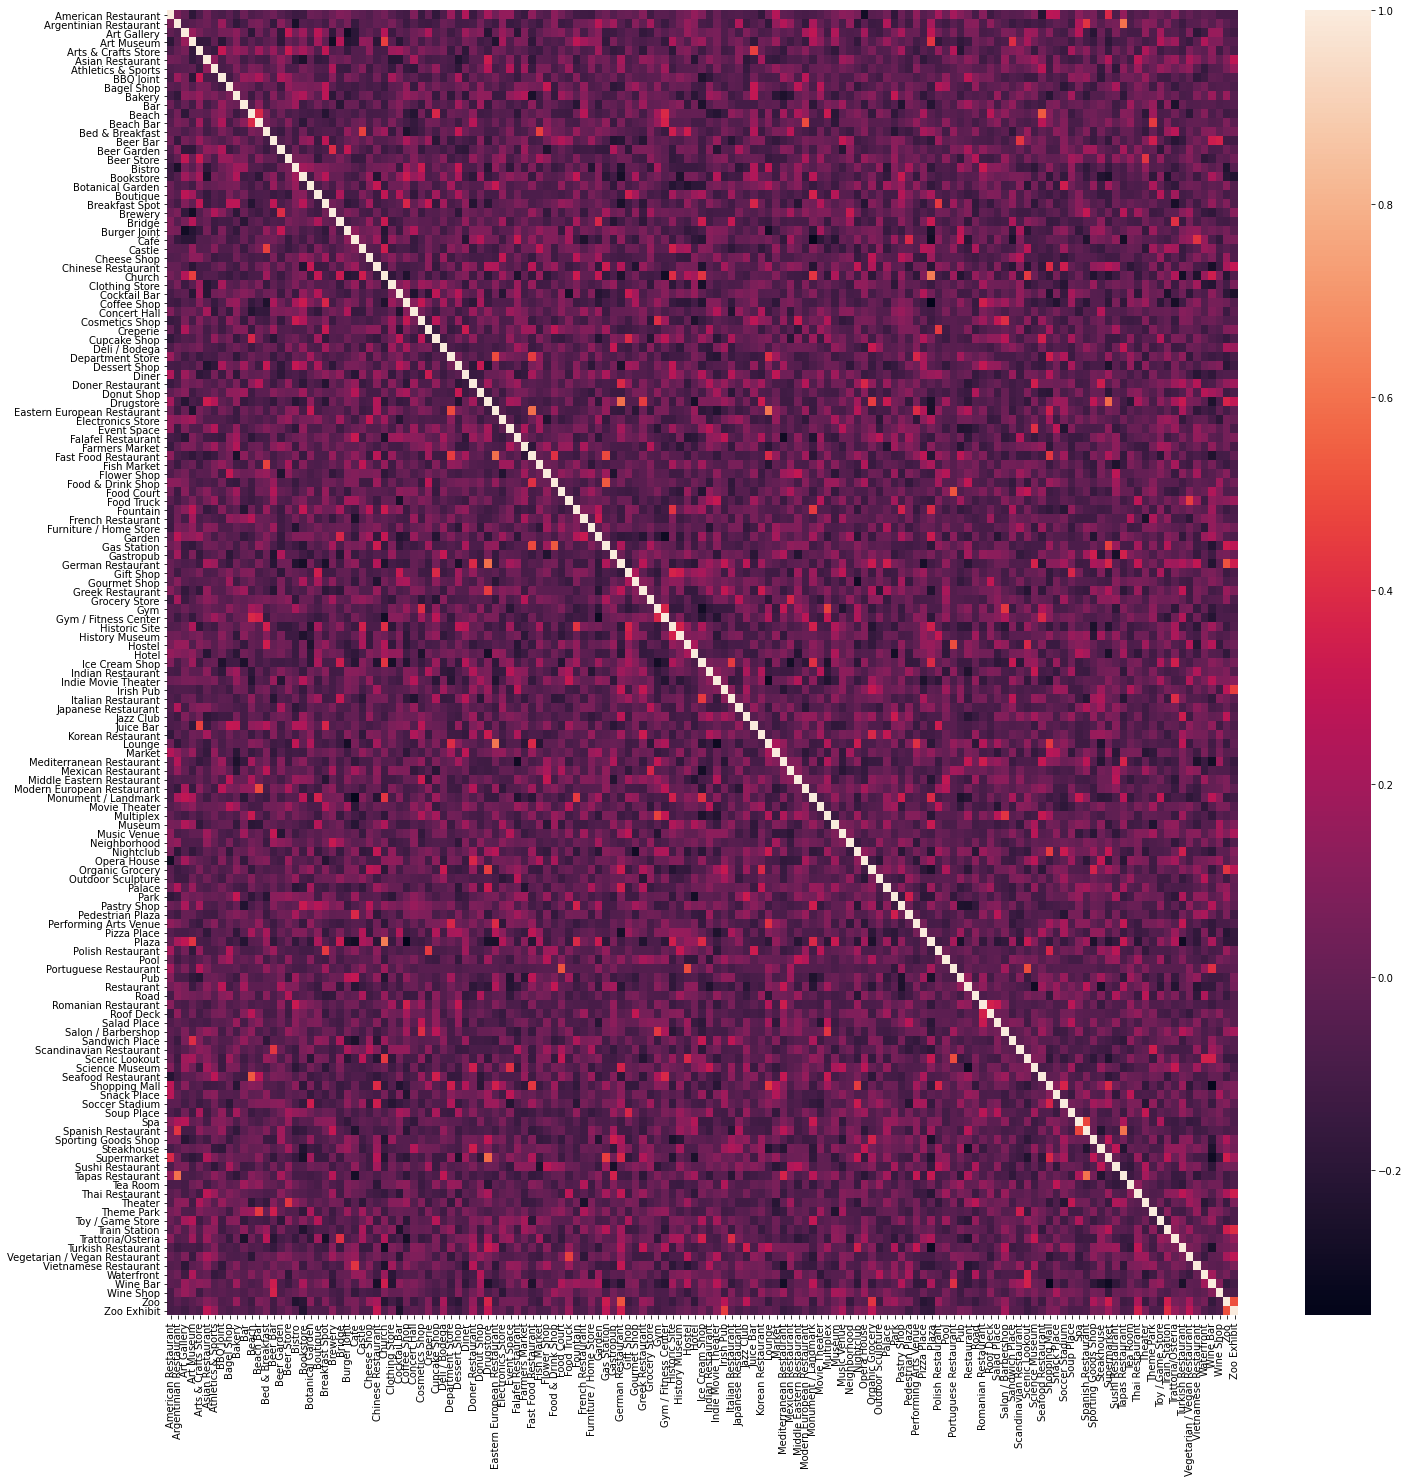

In [20]:
# Converting the correlation matrix to a numpy array
eu_corr_array = np.asarray(eu_corr)

# Getting labels
venues_names = eu_corr.columns

# Plotting the heat map
fig, ax = pyplot.subplots(figsize = (24, 24))
sns.heatmap(eu_corr_array, xticklabels = venues_names, yticklabels = venues_names)

It's a bit small because we still have a lot of different types of venue but we can kind of see what's going on. The lighter the colour, the more correlated two venue categories are. This means that in cities where you find a lot of one kind, you are also quite likely to find a lot of the other kind of venue too. For example, if you look carefully, you can see that cities with a lot of Spanish restaurants also have more Argentinean restaurants and Tapas restaurants. Plazas and churches go hand in hand, as do department stores and bowling alleys. 

## Top types of venue per city

We can also calculate the number of types of different venue category per city. Later on, we're going to calculate the top venue categories per city and if a city doesn't have a certain number of unique venue categories, the results won't make sense.

In [21]:
eu_ncats = eu_cities_onehot.groupby("City").sum().reset_index()

# Looping over all rows and columns. We'll replace all non-zero numbers with a one, then we can calculate how many unique venue types we have per city
for row in range(0, len(eu_ncats)):
    for col in range(1, len(eu_ncats.columns)):
        if eu_ncats.iloc[row, col] > 0: 
            eu_ncats.iloc[row, col] = 1
        else: 
            eu_ncats.iloc[row, col] = 0 

eu_n_cats = pd.concat([eu_ncats["City"], eu_ncats.sum(axis = 1)], axis = 1)
eu_n_cats.rename(columns = {0: "Number of unique venue categories"}, inplace = True)

eu_n_cats

,City,Number of unique venue categories
0,Aarhus,58
1,Alicante,50
2,Amsterdam,57
3,Antwerp,66
4,Athens,46
5,Barcelona,58
6,Bari,44
7,Berlin,54
8,Bielefeld,49
9,Bilbao,55


In [22]:
print("The maximum number of unique venue categories in a city is {} and the mininum number is {}."
      .format(eu_n_cats["Number of unique venue categories"].max(), eu_n_cats["Number of unique venue categories"].min()))
print("The average number of venue categories in a city is {}.".format(eu_n_cats["Number of unique venue categories"].mean()))

The maximum number of unique venue categories in a city is 66 and the mininum number is 30.
The average number of venue categories in a city is 51.56989247311828.


Fortunately, it appears that every city has at least 30 different kinds of venue present in it so we're free to continue. Next we will define a function that takes each row (city) and returns the unique venue categories in that city ordered from most to least in terms of frequency. 

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

Let's now run that on our data.

In [24]:
num_top_venues = 25
indicators = ["st", "nd", "rd"]

# Create columns according to number of top venues
columns = ["City"] 

for ind in np.arange(num_top_venues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind+1))

# Create a new dataframe
eu_venues_sorted = pd.DataFrame(columns = columns)
eu_venues_sorted["City"] = eu_grouped["City"]

for ind in np.arange(eu_grouped.shape[0]):
    eu_venues_sorted.iloc[ind, 1:] = return_most_common_venues(eu_grouped.iloc[ind, :], num_top_venues)

# Display    
eu_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,Aarhus,Café,Park,Coffee Shop,Gym / Fitness Center,Bar,Grocery Store,Discount Store,Beach,Scandinavian Restaurant,Sandwich Place,Italian Restaurant,Beer Bar,Forest,Seafood Restaurant,Athletics & Sports,Restaurant,Cocktail Bar,Pub,Wine Bar,Plaza,Ice Cream Shop,Hotel,Middle Eastern Restaurant,Soccer Stadium,Brewery
1,Alicante,Tapas Restaurant,Plaza,Coffee Shop,Restaurant,Spanish Restaurant,Ice Cream Shop,Supermarket,Hotel,Beach,Park,Burger Joint,Theme Park,Gym,Department Store,Beer Garden,Big Box Store,Breakfast Spot,Sushi Restaurant,Gastropub,Sporting Goods Shop,Wine Bar,French Restaurant,Gourmet Shop,Cafeteria,Movie Theater
2,Amsterdam,Hotel,Bar,Coffee Shop,Breakfast Spot,Sandwich Place,Plaza,Canal,Bookstore,Restaurant,Bakery,Cheese Shop,Grocery Store,Organic Grocery,Cocktail Bar,Dessert Shop,Deli / Bodega,Café,French Restaurant,Garden,Modern European Restaurant,Gastropub,Steakhouse,Bistro,Market,Liquor Store
3,Antwerp,Coffee Shop,Plaza,Breakfast Spot,Clothing Store,Bakery,Bistro,Beer Bar,Cocktail Bar,Restaurant,Cosmetics Shop,Vietnamese Restaurant,Bar,Theater,Belgian Restaurant,Shoe Store,Fish & Chips Shop,Juice Bar,Steakhouse,Opera House,Optical Shop,Lingerie Store,Sushi Restaurant,Sandwich Place,Bookstore,Boutique
4,Athens,Bar,Café,Coffee Shop,Historic Site,Dessert Shop,Boutique,Cocktail Bar,Gourmet Shop,Meze Restaurant,Pedestrian Plaza,Park,Falafel Restaurant,Plaza,Pizza Place,Theater,Hill,History Museum,Kafenio,Wine Bar,Bookstore,Roof Deck,Planetarium,Burger Joint,Souvlaki Shop,Jewelry Store
5,Barcelona,Hotel,Tapas Restaurant,Coffee Shop,Spanish Restaurant,Pizza Place,Mediterranean Restaurant,Bookstore,Garden,Bakery,Clothing Store,Burger Joint,Italian Restaurant,Argentinian Restaurant,Cocktail Bar,Monument / Landmark,Plaza,Dessert Shop,Wine Bar,Wine Shop,Market,Gastropub,Restaurant,Sporting Goods Shop,Roof Deck,Fountain
6,Bari,Pizza Place,Italian Restaurant,Pub,Hotel,Café,Bar,Restaurant,Cocktail Bar,Seafood Restaurant,Ice Cream Shop,Plaza,Burger Joint,Bookstore,Fast Food Restaurant,Beer Garden,Sandwich Place,Beach,Japanese Restaurant,Mobile Phone Shop,Sushi Restaurant,Boutique,Bistro,Gastropub,Gourmet Shop,Steakhouse
7,Berlin,Park,Coffee Shop,Bookstore,Concert Hall,Ice Cream Shop,Wine Bar,Hotel,Bakery,Garden,Indie Movie Theater,Monument / Landmark,Historic Site,Chocolate Shop,Bistro,Gourmet Shop,Beer Bar,Pastry Shop,Sandwich Place,Mediterranean Restaurant,Breakfast Spot,Art Gallery,Art Museum,Church,Volleyball Court,Plaza
8,Bielefeld,Supermarket,Café,Bar,Tram Station,German Restaurant,Chinese Restaurant,Gas Station,Burger Joint,Grocery Store,Mediterranean Restaurant,Bakery,Italian Restaurant,Park,Restaurant,Plaza,Furniture / Home Store,Sushi Restaurant,Mexican Restaurant,Bed & Breakfast,Steakhouse,Middle Eastern Restaurant,Garden,Food & Drink Shop,French Restaurant,Soccer Stadium
9,Bilbao,Tapas Restaurant,Plaza,Hotel,Restaurant,Spanish Restaurant,Deli / Bodega,Gastropub,Café,Wine Bar,Gym / Fitness Center,Bar,Bakery,Outdoor Sculpture,Park,Beer Bar,Seafood Restaurant,Museum,Burrito Place,Lounge,Bistro,Paella Restaurant,General Entertainment,Bookstore,Cocktail Bar,Music Venue


Now that we have our dataframe with the top most common venue types per city, we can start clustering!

## Clustering cities based on venues

Normally we might start with normalising our data. However, given that our data is all in the same dimension (min = 0, max = 1) this is unnecessary. (In addition, experimenting with this and then eyeballing the clusters revealed one large cluster of >90% of the cities, with other tiny clusters of one or two cities each.) Therefore, we will not normalise our data and we will instead run k-means clustering to group our data into clusters of similar cities using the non-normalised data.
<br><br>
Let's first optimise the number of clusters using the "elbow method". This involves running the algorithm using different numbers of clusters (values of k) and visualising the sum of squared distances of samples in a cluster to the nearest cluster centre. Visualising the results allows us to see where there is a sharp decrease in the sum of squared distances - this looks a bit like an elbow in an arm, and is hence why this is called the "elbow method". The value of k at this point is the optimal k. 

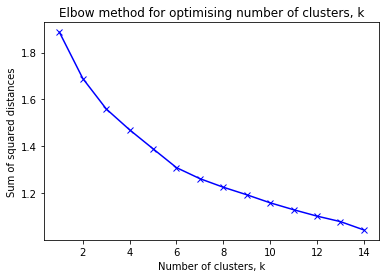

In [25]:
# Drop "City" from the dataframe as we don't need/want to cluster on city name
eu_grouped_clustering = eu_grouped.drop("City", axis = 1)

# Calculating sum of squared distances for values of k between 1 and 14
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42, n_init = 100)
    km = km.fit(eu_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

# Plotting    
pyplot.plot(K, Sum_of_squared_distances, 'bx-')
pyplot.xlabel('Number of clusters, k')
pyplot.ylabel('Sum of squared distances')
pyplot.title('Elbow method for optimising number of clusters, k')
pyplot.show()

Here we do not actually see a very striking bend in the "arm" of the line, but we *can* see a slight tweak around k = 6. Therefore we will treat k = 6 as the optimal number of clusters. 

In [26]:
# Set number of clusters
kclusters = 6

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 42, n_init = 100).fit(eu_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 3, 3, 0, 1, 5, 3, 2, 1], dtype=int32)

In [27]:
eu_clustered = eu_venues_sorted

# Drop cluster label column in the case that it already exists
try: 
    eu_clustered.drop("Cluster numbers", axis = 1, inplace = True)
# If it doesn't already exist, it will throw an error, so in the case that this is the first time we're running a KMC this session, it will print this instead
except: 
    print("This is the first time we are running a k-means clustering")
    
# Add clustering labels
eu_clustered.insert(1, "Cluster numbers", kmeans.labels_ + 1) # Let's adjust them to be 1-6 instead of 0-5

# Combining with country, latitude, and longitude data
eu_clustered = eu_clustered.join(eu_cities_data.set_index("City"), on = "City")

eu_clustered.head()

This is the first time we are running a k-means clustering


,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
0,Aarhus,1,Café,Park,Coffee Shop,Gym / Fitness Center,Bar,Grocery Store,Discount Store,Beach,Scandinavian Restaurant,Sandwich Place,Italian Restaurant,Beer Bar,Forest,Seafood Restaurant,Athletics & Sports,Restaurant,Cocktail Bar,Pub,Wine Bar,Plaza,Ice Cream Shop,Hotel,Middle Eastern Restaurant,Soccer Stadium,Brewery,Denmark,349977,56.1496,10.2134
1,Alicante,2,Tapas Restaurant,Plaza,Coffee Shop,Restaurant,Spanish Restaurant,Ice Cream Shop,Supermarket,Hotel,Beach,Park,Burger Joint,Theme Park,Gym,Department Store,Beer Garden,Big Box Store,Breakfast Spot,Sushi Restaurant,Gastropub,Sporting Goods Shop,Wine Bar,French Restaurant,Gourmet Shop,Cafeteria,Movie Theater,Spain,331577,38.3537,-0.490185
2,Amsterdam,4,Hotel,Bar,Coffee Shop,Breakfast Spot,Sandwich Place,Plaza,Canal,Bookstore,Restaurant,Bakery,Cheese Shop,Grocery Store,Organic Grocery,Cocktail Bar,Dessert Shop,Deli / Bodega,Café,French Restaurant,Garden,Modern European Restaurant,Gastropub,Steakhouse,Bistro,Market,Liquor Store,Netherlands,873289,52.3728,4.8936
3,Antwerp,4,Coffee Shop,Plaza,Breakfast Spot,Clothing Store,Bakery,Bistro,Beer Bar,Cocktail Bar,Restaurant,Cosmetics Shop,Vietnamese Restaurant,Bar,Theater,Belgian Restaurant,Shoe Store,Fish & Chips Shop,Juice Bar,Steakhouse,Opera House,Optical Shop,Lingerie Store,Sushi Restaurant,Sandwich Place,Bookstore,Boutique,Belgium,525935,51.2211,4.39971
4,Athens,1,Bar,Café,Coffee Shop,Historic Site,Dessert Shop,Boutique,Cocktail Bar,Gourmet Shop,Meze Restaurant,Pedestrian Plaza,Park,Falafel Restaurant,Plaza,Pizza Place,Theater,Hill,History Museum,Kafenio,Wine Bar,Bookstore,Roof Deck,Planetarium,Burger Joint,Souvlaki Shop,Jewelry Store,Greece,664046,37.9839,23.7283


Now let's inspect our clusters. Let's start with taking a look at the map to see how closely or how far apart our clusters are spread. 

In [28]:
# Create map using the same Europe latitude and longitude coordinates as above
map_clusters = folium.Map(location = [lat_europe, long_europe], zoom_start = 4)

# Set colour scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, city, country, population, cluster in zip(eu_clustered["Latitude"], 
                                                        eu_clustered["Longitude"], 
                                                        eu_clustered["City"],
                                                        eu_clustered["Country"], 
                                                        eu_clustered["Population"],
                                                        eu_clustered["Cluster numbers"]):
    label = "{}, {} (population: {:,} -- cluster {})".format(city, country, population, cluster)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
    
map_clusters

In [29]:
map_clusters.save("map_eu_city_clusters.html")

### Cluster 1

In [31]:
eu_one = eu_clustered.loc[eu_clustered["Cluster numbers"] == 1]
eu_one

,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
4,Athens,1,Historic Site,Café,Coffee Shop,Bar,Dessert Shop,Ice Cream Shop,Wine Bar,Meze Restaurant,History Museum,Hill,Falafel Restaurant,Theater,Boutique,Cocktail Bar,Sushi Restaurant,Park,Pedestrian Plaza,Gourmet Shop,Bookstore,Hotel,Middle Eastern Restaurant,Modern Greek Restaurant,Fish Taverna,Garden,Movie Theater,Greece,664046,37.9839,23.7283
13,Bratislava,1,Café,Coffee Shop,Park,Hotel,Plaza,Vegetarian / Vegan Restaurant,Thai Restaurant,Vietnamese Restaurant,Bookstore,Church,Art Gallery,Health Food Store,Creperie,Wine Bar,Burger Joint,Farmers Market,Historic Site,Speakeasy,Radio Station,Beer Garden,Street Food Gathering,Clothing Store,Bistro,Beer Bar,Garden,Slovakia,432864,48.1517,17.1093
15,Brno,1,Café,Park,Coffee Shop,Pub,Vietnamese Restaurant,Bar,Indian Restaurant,Gym / Fitness Center,Pizza Place,Cocktail Bar,Beer Bar,Dessert Shop,Hotel,Bistro,Building,Mexican Restaurant,Garden,Fountain,Sushi Restaurant,Food & Drink Shop,Gift Shop,Flower Shop,Italian Restaurant,Burger Joint,Fast Food Restaurant,Czech Republic,381346,49.1922,16.6113
26,Dortmund,1,Café,Park,Italian Restaurant,Hotel,Nightclub,Burger Joint,Turkish Restaurant,Ice Cream Shop,Brewery,German Restaurant,Sushi Restaurant,Supermarket,Mediterranean Restaurant,Museum,Bar,Restaurant,Doner Restaurant,Pub,Coffee Shop,Thai Restaurant,Soccer Stadium,Shopping Mall,Sports Bar,Spanish Restaurant,Food Truck,Germany,587010,51.5142,7.46528
28,Dublin,1,Café,Coffee Shop,Pub,Park,Plaza,Italian Restaurant,Hotel,Cocktail Bar,Pizza Place,Historic Site,Bookstore,Chinese Restaurant,Irish Pub,Fried Chicken Joint,Whisky Bar,Gelato Shop,Bistro,Mexican Restaurant,Steakhouse,Stadium,Middle Eastern Restaurant,Falafel Restaurant,French Restaurant,Tea Room,Breakfast Spot,Ireland,554554,53.3498,-6.26027
30,Düsseldorf,1,Café,Park,Coffee Shop,Plaza,Cocktail Bar,Sushi Restaurant,Beer Garden,Bakery,Italian Restaurant,Pizza Place,Mexican Restaurant,Grocery Store,Japanese Restaurant,Pedestrian Plaza,Ramen Restaurant,Brewery,Steakhouse,Theater,Hotel,Vietnamese Restaurant,Arts & Crafts Store,Supermarket,Jewish Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Germany,619294,51.2254,6.77631
31,Essen,1,Café,Doner Restaurant,Burger Joint,Italian Restaurant,Pub,Falafel Restaurant,Historic Site,Bakery,Restaurant,Concert Hall,Coffee Shop,Art Museum,Steakhouse,Drugstore,Bar,Hotel,Supermarket,Plaza,Park,Turkish Restaurant,Vegetarian / Vegan Restaurant,Indie Movie Theater,History Museum,Ice Cream Shop,Pizza Place,Germany,583393,51.4582,7.01582
33,Frankfurt,1,Café,Park,Plaza,Apple Wine Pub,Coffee Shop,Bar,Bakery,Scenic Lookout,Restaurant,Lounge,Thai Restaurant,Cocktail Bar,Gastropub,Art Museum,Sushi Restaurant,Greek Restaurant,Waterfront,Hotel,Vietnamese Restaurant,Wine Bar,Falafel Restaurant,River,Beer Garden,Sandwich Place,German Restaurant,Germany,753056,50.1106,8.68209
35,Gdańsk,1,Hotel,Café,Pizza Place,Hostel,Historic Site,History Museum,Cocktail Bar,Beer Bar,Bar,Sushi Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Chinese Restaurant,Polish Restaurant,Plaza,Ice Cream Shop,Music Venue,Neighborhood,Modern European Restaurant,Brewery,Soup Place,Fountain,Fish & Chips Shop,Burger Joint,French Restaurant,Poland,471525,54.3614,18.6282
41,Iași,1,Café,Coffee Shop,Park,Italian Restaurant,Hotel,Mediterranean Restaurant,Restaurant,Romanian Restaurant,Lounge,Plaza,Dessert Shop,Pub,Bar,Vegetarian /

Let's look at what these cities have in common.

In [32]:
def common_venues(cluster): 

    # Instantiate the dataframe with the first column of the cluster 
    venues_cluster = cluster.iloc[:,2].value_counts().rename_axis("unique_venues").reset_index(name = "count")

    # Loop over the other most common venue columns and append them 
    for n in range(3,28):
        new = cluster.iloc[:,n].value_counts().rename_axis("unique_venues").reset_index(name = "count")
        venues_cluster = venues_cluster.append(new)
    
    # Some venues show up in multiple columns. Grouping them gets us one count for the whole dataframe 
    venues_cluster = venues_cluster.groupby("unique_venues").sum()

    # Let's add in an extra column so we can see the percentage of postcodes in the cluster that have that venue
    percentage = venues_cluster["count"]/len(cluster) * 100
    percentage = pd.DataFrame(percentage)
    percentage.rename(columns = {"count": "percentage"}, inplace = True)
    venues_cluster = pd.concat([venues_cluster, percentage], axis = 1)

    # Let's also only look at venues that are present in more than 40% of cities in the cluster 
    return(venues_cluster[venues_cluster["percentage"] > 40].sort_values("count", ascending = False))

In [33]:
common_venues(eu_one)

,count,percentage
unique_venues,,
Café,18,100.000000
Coffee Shop,18,100.000000
Hotel,18,100.000000
Park,16,88.888889
Plaza,15,83.333333
Bar,13,72.222222
Burger Joint,10,55.555556
Pizza Place,10,55.555556
Ice Cream Shop,9,50.000000


### Cluster 2

In [34]:
eu_two = eu_clustered.loc[eu_clustered["Cluster numbers"] == 2]
eu_two

,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
6,Bari,2,Pizza Place,Italian Restaurant,Hotel,Pub,Bar,Restaurant,Café,Cocktail Bar,Seafood Restaurant,Ice Cream Shop,Japanese Restaurant,Fast Food Restaurant,Bookstore,Beach,Plaza,Beer Garden,Burger Joint,Sandwich Place,Cupcake Shop,Gourmet Shop,Gym / Fitness Center,Lighthouse,Electronics Store,Coffee Shop,Bistro,Italy,320862,41.1258,16.862
11,Bologna,2,Ice Cream Shop,Italian Restaurant,Plaza,Café,Park,Monument / Landmark,Coffee Shop,Beer Bar,Electronics Store,Cupcake Shop,Sandwich Place,Seafood Restaurant,Hotel,Wine Bar,Fish Market,Church,Museum,Pool,Miscellaneous Shop,Persian Restaurant,Grocery Store,Butcher,Greek Restaurant,Gourmet Shop,Bistro,Italy,390636,44.4938,11.343
19,Catania,2,Plaza,Italian Restaurant,Pizza Place,Dessert Shop,Café,Historic Site,Burger Joint,Bed & Breakfast,Hotel,Cocktail Bar,Vegetarian / Vegan Restaurant,Pub,Fish Market,Trattoria/Osteria,Fountain,Hostel,Arepa Restaurant,Beer Store,Supermarket,Fast Food Restaurant,Steakhouse,Gastropub,Garden,Bookstore,Mediterranean Restaurant,Italy,311584,37.5022,15.0874
27,Dresden,2,Plaza,German Restaurant,Hotel,Art Gallery,Park,Doner Restaurant,Science Museum,Coffee Shop,Vegetarian / Vegan Restaurant,Bakery,Ice Cream Shop,Museum,Field,Historic Site,Supermarket,Modern European Restaurant,Lounge,Garden,Steakhouse,Cocktail Bar,Gastropub,Opera House,Big Box Store,Beer Store,Electronics Store,Germany,554649,51.0493,13.7381
32,Florence,2,Hotel,Italian Restaurant,Plaza,Ice Cream Shop,Sandwich Place,Trattoria/Osteria,Art Museum,Church,Boutique,Art Gallery,Winery,Pizza Place,Scenic Lookout,Café,Bookstore,Bar,Bakery,History Museum,Bridge,American Restaurant,Outdoor Sculpture,Pub,Candy Store,Museum,Science Museum,Italy,378839,43.7699,11.2556
36,Genoa,2,Italian Restaurant,Hotel,Plaza,Pizza Place,Ice Cream Shop,Seafood Restaurant,Historic Site,Café,Beach,Trattoria/Osteria,Science Museum,Bar,Boat or Ferry,Steakhouse,Mediterranean Restaurant,Gym / Fitness Center,Cocktail Bar,Theater,Ligurian Restaurant,Pool,Burger Joint,Bridge,Museum,Garden,Furniture / Home Store,Italy,578000,44.4073,8.93386
46,Lisbon,2,Plaza,Scenic Lookout,Hotel,Hostel,Portuguese Restaurant,Café,Ice Cream Shop,Wine Bar,Garden,Restaurant,Cocktail Bar,Food Court,Indian Restaurant,Bar,Lounge,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,American Restaurant,Waterfront,Concert Hall,Road,Church,Castle,Candy Store,Portugal,506654,38.7078,-9.13659
53,Milan,2,Hotel,Plaza,Boutique,Italian Restaurant,Ice Cream Shop,Park,Monument / Landmark,Art Museum,Dessert Shop,Café,Art Gallery,Museum,Bakery,Pizza Place,Wine Bar,Hostel,Historic Site,Sushi Restaurant,Bookstore,Cocktail Bar,Church,Coffee Shop,Pastry Shop,Sandwich Place,Restaurant,Italy,1404239,45.4668,9.1905
59,Naples,2,Pizza Place,Plaza,Historic Site,Café,Castle,Hotel,Italian Restaurant,History Museum,Church,Scenic Lookout,Park,Art Museum,Dessert Shop,Ice Cream Shop,Island,Rest Area,Light Rail Station,Museum,Rental Car Location,Sandwich Place,Bed & Breakfast,Fast Food Restaurant,Restaurant,Wine Bar,Speakeasy,Italy,959188,40.8359,14.2488
62,Palermo,2,Italian Restaurant,Ice Cream Shop,Plaza,Café,Pizza Place,Bar,Historic Site,Bistro,Park,Restaurant,Museum,Wine Shop,Dessert Shop,Mediterranean Restaurant,Sandwich Place,Snack Place,Market,Garden,Lounge,Gastropub,Church,Seafood Restaurant,Pub,Shopping Mall,Art Gallery,Italy,663401,38.1112,13.3524


Let's look at what these cities have in common.

In [35]:
common_venues(eu_two)

,count,percentage
unique_venues,,
Plaza,14,100.000000
Hotel,13,92.857143
Café,12,85.714286
Ice Cream Shop,12,85.714286
Italian Restaurant,11,78.571429
Italy,10,71.428571
Historic Site,9,64.285714
Pizza Place,9,64.285714
Coffee Shop,9,64.285714


### Cluster 3

In [36]:
eu_three = eu_clustered.loc[eu_clustered["Cluster numbers"] == 3]
eu_three

,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
1,Alicante,3,Tapas Restaurant,Spanish Restaurant,Plaza,Supermarket,Ice Cream Shop,Restaurant,Beach,Coffee Shop,Hotel,Department Store,Park,Paella Restaurant,Gym,Shopping Mall,Theme Park,Sushi Restaurant,Sporting Goods Shop,Light Rail Station,Big Box Store,Mediterranean Restaurant,Italian Restaurant,Burger Joint,Farmers Market,Castle,College Cafeteria,Spain,331577,38.3537,-0.490185
5,Barcelona,3,Hotel,Tapas Restaurant,Coffee Shop,Monument / Landmark,Burger Joint,Mediterranean Restaurant,Wine Bar,Pizza Place,Spanish Restaurant,Plaza,Italian Restaurant,Donut Shop,Concert Hall,Park,Ice Cream Shop,Market,Bookstore,Beer Bar,Bakery,Scenic Lookout,Spa,Fountain,Mexican Restaurant,Food & Drink Shop,Café,Spain,1620343,41.3829,2.17743
9,Bilbao,3,Tapas Restaurant,Hotel,Spanish Restaurant,Restaurant,Plaza,Deli / Bodega,Café,Wine Bar,Gastropub,Outdoor Sculpture,Park,Museum,Supermarket,Beer Bar,Bar,Bakery,Seafood Restaurant,Hostel,Convention Center,Fried Chicken Joint,Lounge,Bistro,Pedestrian Plaza,Cocktail Bar,Clothing Store,Spain,345821,43.263,-2.935
25,Córdoba,3,Spanish Restaurant,Hotel,Tapas Restaurant,Plaza,Park,Brewery,Cocktail Bar,Wine Bar,Bar,History Museum,Theater,Ice Cream Shop,Spa,Restaurant,Mediterranean Restaurant,Mexican Restaurant,Garden,Market,Furniture / Home Store,Beer Garden,Café,Monument / Landmark,Mosque,Museum,Nightclub,Spain,325708,37.8846,-4.77601
44,Las Palmas,3,Restaurant,Tapas Restaurant,Spanish Restaurant,Plaza,Park,Mediterranean Restaurant,Hotel,Coffee Shop,Beach,Italian Restaurant,Burger Joint,Surf Spot,Seafood Restaurant,Theater,Bar,Beer Garden,Ice Cream Shop,Vegetarian / Vegan Restaurant,Japanese Restaurant,Concert Hall,Performing Arts Venue,Snack Place,Salad Place,Soccer Stadium,Gastropub,Spain,378517,28.1289,-15.4349
49,Madrid,3,Plaza,Restaurant,Hotel,Café,Spanish Restaurant,Theater,Coffee Shop,Art Museum,Tapas Restaurant,Hostel,Bookstore,Cocktail Bar,Market,Bistro,Gourmet Shop,Art Gallery,Argentinian Restaurant,Mediterranean Restaurant,Pizza Place,Garden,Electronics Store,Clothing Store,Sushi Restaurant,Road,Roof Deck,Spain,3348536,40.4167,-3.70358
55,Murcia,3,Spanish Restaurant,Restaurant,Plaza,Tapas Restaurant,Café,Mediterranean Restaurant,Hotel,Gym,Park,Vegetarian / Vegan Restaurant,Japanese Restaurant,Coffee Shop,Grocery Store,Concert Hall,Cocktail Bar,Multiplex,Nightclub,Paella Restaurant,Asian Restaurant,Seafood Restaurant,Stadium,Theater,Pizza Place,Bar,Food,Spain,447182,37.9924,-1.13054
56,Málaga,3,Ice Cream Shop,Spanish Restaurant,Tapas Restaurant,Art Museum,Hotel,Mediterranean Restaurant,Plaza,Restaurant,Beach,Café,Seafood Restaurant,Tea Room,Bakery,Beer Bar,Pub,Historic Site,Bike Rental / Bike Share,Park,Scenic Lookout,Snack Place,Sporting Goods Shop,Brewery,Soccer Stadium,Spa,Boarding House,Spain,571026,36.7213,-4.42164
63,Palma de Mallorca,3,Mediterranean Restaurant,Hotel,Tapas Restaurant,Coffee Shop,Spanish Restaurant,Plaza,Café,Thai Restaurant,Restaurant,Sports Club,Bar,Snack Place,Seafood Restaurant,Farmers Market,Italian Restaurant,Park,Diner,Market,Golf Course,Pizza Place,Bookstore,Mexican Restaurant,Garden,Sushi Restaurant,Steakhouse,Spain,409661,39.5696,2.65007
71,Seville,3,Tapas Restaurant,Spanish Restaurant,Plaza,Park,Hotel,Café,Theater,Gastropub,Monument / Landmark,Historic Site,Argentinian Restaurant,Mediterranean Restaurant,Garden,Museum,Art Museum,Restaurant,Cocktail B

Let's look at what these cities have in common.

In [37]:
common_venues(eu_three)

,count,percentage
unique_venues,,
Tapas Restaurant,12,100.000000
Spanish Restaurant,12,100.000000
Hotel,12,100.000000
Spain,12,100.000000
Plaza,12,100.000000
Restaurant,11,91.666667
Mediterranean Restaurant,11,91.666667
Park,11,91.666667
Café,10,83.333333


### Cluster 4

In [38]:
eu_four = eu_clustered.loc[eu_clustered["Cluster numbers"] == 4]
eu_four

,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
8,Bielefeld,4,Supermarket,Bar,Café,Burger Joint,Gas Station,Bakery,Restaurant,Chinese Restaurant,Park,Plaza,Hotel,Mediterranean Restaurant,Sushi Restaurant,Light Rail Station,Mexican Restaurant,Big Box Store,German Restaurant,Bed & Breakfast,Steakhouse,Garden,Italian Restaurant,French Restaurant,Soccer Stadium,Food & Drink Shop,Greek Restaurant,Germany,333786,52.0191,8.53101
10,Bochum,4,Supermarket,Bakery,Park,Ice Cream Shop,Drugstore,Theater,Greek Restaurant,Asian Restaurant,Snack Place,Tapas Restaurant,Butcher,Café,Trattoria/Osteria,Sushi Restaurant,Concert Hall,German Restaurant,American Restaurant,Pizza Place,Event Space,Shopping Mall,Italian Restaurant,Burger Joint,Mobile Phone Shop,Science Museum,Bratwurst Joint,Germany,364628,51.4818,7.21966
12,Bonn,4,Supermarket,Italian Restaurant,Plaza,Ice Cream Shop,Greek Restaurant,Park,Café,Bakery,Movie Theater,Hotel,Pub,Bar,Asian Restaurant,Drugstore,History Museum,Indian Restaurant,Vietnamese Restaurant,German Restaurant,Korean Restaurant,Science Museum,Road,Coffee Shop,Burrito Place,Restaurant,Resort,Germany,327258,50.7359,7.10066
14,Bremen,4,Italian Restaurant,Hotel,Bar,Café,Restaurant,Supermarket,German Restaurant,Outdoor Sculpture,Plaza,Ice Cream Shop,Burger Joint,Burrito Place,Sandwich Place,Vegetarian / Vegan Restaurant,Indie Movie Theater,Park,Lake,Falafel Restaurant,Steakhouse,Market,Soccer Field,Irish Pub,Korean Restaurant,Road,Middle Eastern Restaurant,Germany,569352,53.0758,8.80716
24,Craiova,4,Hotel,Bar,Restaurant,Café,Pub,Park,Fast Food Restaurant,Eastern European Restaurant,Supermarket,Greek Restaurant,Lounge,Clothing Store,Italian Restaurant,Pizza Place,Coffee Shop,Bowling Alley,Department Store,Bakery,Ice Cream Shop,Bistro,Bookstore,Gastropub,Sporting Goods Shop,Romanian Restaurant,Market,Romania,305386,44.319,23.7966
29,Duisburg,4,Café,Supermarket,Restaurant,Zoo Exhibit,Vegetarian / Vegan Restaurant,Ice Cream Shop,Thai Restaurant,Pub,Train Station,Asian Restaurant,Drugstore,Pool Hall,Plaza,Pet Store,Park,Other Great Outdoors,Salon / Barbershop,Music Venue,Mongolian Restaurant,Liquor Store,Zoo,Indie Movie Theater,Hardware Store,Hostel,Golf Course,Germany,498590,51.435,6.75956
34,Galați,4,Hotel,Lounge,Eastern European Restaurant,Café,Supermarket,Cocktail Bar,Park,Fast Food Restaurant,Shopping Mall,Pizza Place,Department Store,Chinese Restaurant,Soccer Stadium,Bowling Alley,Botanical Garden,Coffee Shop,Restaurant,Italian Restaurant,Dessert Shop,Bistro,Nightclub,Food,French Restaurant,Garden,Mediterranean Restaurant,Romania,304050,45.4338,28.0549
42,Karlsruhe,4,Café,Italian Restaurant,Supermarket,Drugstore,German Restaurant,Plaza,Greek Restaurant,Chinese Restaurant,Bakery,Coffee Roaster,Middle Eastern Restaurant,Museum,Furniture / Home Store,Organic Grocery,Coffee Shop,Palace,Park,Ice Cream Shop,Gym / Fitness Center,Sporting Goods Shop,Botanical Garden,Market,Gastropub,Steakhouse,South Indian Restaurant,Germany,313092,49.0069,8.40342
47,Lublin,4,Café,Hotel,Bar,Supermarket,Plaza,Restaurant,Art Gallery,Shopping Mall,Pub,Nightclub,Chinese Restaurant,Park,Coffee Shop,History Museum,Beer Bar,Spa,Polish Restaurant,Soccer Stadium,Breakfast Spot,Italian Restaurant,Pool,Creperie,Diner,Electronics Store,Museum,Poland,339547,51.2182,22.5547
48,Lyon,4,Plaza,Bar,Supermarket,French Restaurant,Café,Lyonese Bouchon,Park,Bakery,Hotel,Farmers Market,Wine Bar,Cocktail Bar

Let's look at what these cities have in common.

In [39]:
common_venues(eu_four)

,count,percentage
unique_venues,,
Supermarket,14,100.000000
Café,14,100.000000
Park,14,100.000000
Italian Restaurant,11,78.571429
Ice Cream Shop,10,71.428571
Restaurant,10,71.428571
Plaza,10,71.428571
Bar,9,64.285714
Hotel,9,64.285714


### Cluster 5

In [40]:
eu_five = eu_clustered.loc[eu_clustered["Cluster numbers"] == 5]
eu_five

,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
0,Aarhus,5,Grocery Store,Café,Park,Discount Store,Gym / Fitness Center,Hotel,Coffee Shop,Italian Restaurant,Beach,Sandwich Place,Restaurant,Botanical Garden,Forest,Seafood Restaurant,Scandinavian Restaurant,Supermarket,Athletics & Sports,Wine Bar,Plaza,Ice Cream Shop,Fish Market,Bike Trail,Cultural Center,Bowling Alley,French Restaurant,Denmark,349977,56.1496,10.2134
2,Amsterdam,5,Coffee Shop,Hotel,Bar,Café,Bakery,Pizza Place,Canal,Plaza,Restaurant,Italian Restaurant,Organic Grocery,Burger Joint,Grocery Store,Sandwich Place,Cheese Shop,Marijuana Dispensary,Park,Dessert Shop,Deli / Bodega,Wine Bar,Electronics Store,Shopping Mall,Market,Steakhouse,Bistro,Netherlands,873289,52.3728,4.8936
3,Antwerp,5,Coffee Shop,Belgian Restaurant,Clothing Store,Bakery,Bar,Plaza,Cocktail Bar,Gym,Juice Bar,Sandwich Place,Theater,Sushi Restaurant,Breakfast Spot,French Restaurant,Bistro,Beer Bar,Bagel Shop,Boutique,Smoke Shop,Spanish Restaurant,Molecular Gastronomy Restaurant,Frozen Yogurt Shop,Shopping Plaza,Botanical Garden,Gastropub,Belgium,525935,51.2211,4.39971
7,Berlin,5,Coffee Shop,Bookstore,Park,Concert Hall,Bistro,Monument / Landmark,Ice Cream Shop,Indie Movie Theater,Beer Bar,Gourmet Shop,Historic Site,Café,Science Museum,Bakery,Hotel,Wine Bar,Pastry Shop,Garden,Yoga Studio,Shopping Mall,Seafood Restaurant,Italian Restaurant,Middle Eastern Restaurant,Brewery,Fountain,Germany,3669495,52.517,13.3889
16,Bucharest,5,Coffee Shop,Dessert Shop,Hotel,Italian Restaurant,Pub,Mediterranean Restaurant,Gastropub,Bookstore,Restaurant,Romanian Restaurant,Tea Room,Plaza,Park,Theater,Monastery,Roof Deck,Supermarket,Pizza Place,Gym / Fitness Center,Bar,Bistro,Burger Joint,Cupcake Shop,Cosmetics Shop,Spa,Romania,1832883,44.4361,26.1027
17,Budapest,5,Coffee Shop,Hotel,Pizza Place,Bakery,Dessert Shop,Italian Restaurant,Park,Playground,Theater,Breakfast Spot,Indie Movie Theater,Historic Site,Bistro,Sandwich Place,Gourmet Shop,Tea Room,Plaza,Mountain,Mediterranean Restaurant,Beer Bar,Lounge,Outdoor Sculpture,Bookstore,Cocktail Bar,Spa,Hungary,1752286,47.4984,19.0405
18,Bydgoszcz,5,Hotel,Restaurant,Fast Food Restaurant,Café,Coffee Shop,Ice Cream Shop,Burger Joint,Park,Sushi Restaurant,Eastern European Restaurant,Stadium,Gas Station,Historic Site,Creperie,Breakfast Spot,Brewery,Hookah Bar,Island,Shopping Mall,Chinese Restaurant,Lounge,Comfort Food Restaurant,Pub,Polish Restaurant,Miscellaneous Shop,Poland,346739,53.1297,18.0294
20,Cluj-Napoca,5,Bakery,Coffee Shop,Restaurant,Park,Pub,Hotel,Café,Bistro,Bookstore,Gym / Fitness Center,Plaza,Bar,Cocktail Bar,Italian Restaurant,Gym,Nightclub,Lounge,Juice Bar,Ice Cream Shop,Sports Bar,Indian Restaurant,Botanical Garden,Soup Place,Soccer Stadium,Japanese Restaurant,Romania,324960,46.7694,23.59
21,Cologne,5,Park,Café,Coffee Shop,Plaza,Pedestrian Plaza,Italian Restaurant,Hotel,Ice Cream Shop,Japanese Restaurant,Falafel Restaurant,Restaurant,Cocktail Bar,German Restaurant,French Restaurant,Zoo,Vegetarian / Vegan Restaurant,Beer Garden,Pub,Deli / Bodega,Waterfront,Scenic Lookout,Spa,Middle Eastern Restaurant,Sporting Goods Shop,Breakfast Spot,Germany,1085664,50.9384,6.95997
22,Constanța,5,Coffee Shop,Pizza Place,Gym,Gym / Fitness Center,Mediterranean Restaurant,Café,Italian Restaurant,Cocktail Bar,Restaurant,Lounge,Multiplex,Clothing Store,Casino,Park,Nightclub,Shopping Mall,Dessert Shop,Salon / Barbershop,Burge

Let's look at what these cities have in common.

In [41]:
common_venues(eu_five)

,count,percentage
unique_venues,,
Coffee Shop,31,100.000000
Park,30,96.774194
Café,28,90.322581
Hotel,25,80.645161
Plaza,22,70.967742
Restaurant,22,70.967742
Bakery,20,64.516129
Italian Restaurant,20,64.516129
Bar,17,54.838710


### Cluster 6

In [42]:
eu_six = eu_clustered.loc[eu_clustered["Cluster numbers"] == 6]
eu_six

,City,Cluster numbers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,Country,Population,Latitude,Longitude
52,Marseille,6,French Restaurant,Plaza,Bar,Park,Beach,Art Museum,Hotel,Historic Site,Pizza Place,Provençal Restaurant,Tapas Restaurant,Shopping Mall,Bakery,Roof Deck,Bay,Nightclub,Seafood Restaurant,Church,Coffee Shop,Lounge,Waterfront,Café,Cultural Center,Soccer Stadium,Mediterranean Restaurant,France,862211,43.2962,5.36995
58,Nantes,6,French Restaurant,Bar,Plaza,Bakery,Restaurant,Pizza Place,Park,Historic Site,Bistro,Coffee Shop,Theme Park,Concert Hall,Indian Restaurant,Wine Bar,Hotel,Greek Restaurant,Garden,Church,Indie Movie Theater,Cocktail Bar,Roof Deck,Chinese Restaurant,Comedy Club,Science Museum,Castle,France,306694,47.2186,-1.55414
60,Nice,6,French Restaurant,Beach,Hotel,Italian Restaurant,Park,Café,Ice Cream Shop,Pizza Place,Mediterranean Restaurant,Lounge,Plaza,Hill,Bakery,Historic Site,Restaurant,Seafood Restaurant,Cupcake Shop,Scenic Lookout,Gift Shop,Coffee Shop,Stationery Store,Outdoor Sculpture,Supermarket,Gourmet Shop,Candy Store,France,342637,43.7009,7.26839
80,Toulouse,6,French Restaurant,Plaza,Bar,Pub,Garden,Hotel,Burger Joint,Tea Room,Restaurant,Ice Cream Shop,Wine Bar,Coffee Shop,Department Store,Sandwich Place,Concert Hall,Art Museum,Park,Soccer Stadium,Snack Place,Steakhouse,Food,Bowling Alley,Bookstore,Farmers Market,Stadium,France,479638,43.6045,1.44425


Let's look at what these cities have in common.

In [43]:
common_venues(eu_six)

,count,percentage
unique_venues,,
Hotel,4,100.0
Coffee Shop,4,100.0
France,4,100.0
French Restaurant,4,100.0
Plaza,4,100.0
Park,4,100.0
Bar,3,75.0
Restaurant,3,75.0
Historic Site,3,75.0


## Visualising our results

Let's take a look at what we found! Next we'll produce some graphs to look at what these cities have in common and what they do not. 

In [44]:
eu_grouped_clustered = eu_grouped
    
# Add clustering labels
try: 
    eu_grouped_clustered.insert(1, "Cluster numbers", kmeans.labels_ + 1)
except: 
    print("Not the first time we've done this")

# Display 
eu_grouped_clustered.head()

,City,Cluster numbers,Accessories Store,Advertising Agency,African Restaurant,Airport,Airport Service,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Library,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cretan Restaurant,Cruise Ship,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Manti Place,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Ouzeri,Paella Restaurant,Pakistani Restaurant,Palace,Paper / Office Supplies

Now let's drop the city name and group by the cluster to get the mean relative frequency of venue categories for each cluster. Then we can start visualising! 

In [45]:
# Drop cluster label column in the case that it already exists
try: 
    eu_grouped_clustered.drop("City", axis = 1, inplace = True)
except: 
    print("Not the first time we've done this")
    
# Group by cluster number
eu_grouped_clustered = eu_grouped_clustered.groupby("Cluster numbers").mean().reset_index()

# Convert to percentages for easier reading
eu_grouped_clustered.iloc[:,1:] = eu_grouped_clustered.iloc[:,1:] * 100

# Display
eu_grouped_clustered

,Cluster numbers,Accessories Store,Advertising Agency,African Restaurant,Airport,Airport Service,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Library,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cretan Restaurant,Cruise Ship,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Manti Place,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monastery,Mongolian Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Ouzeri,Paella Restaurant,Pakistani Restaurant,Palace,Paper / Office Supplies Stor

Let's now do some visualisations. We can first look at different types of restaurant for example.  

In [46]:
# Set cluster number as index
eu_grouped_clustered.set_index("Cluster numbers", drop = True, inplace = True)

In [47]:
# Relative frequencies of different sorts of restaurant
df_restaurants = eu_grouped_clustered.filter(like = "Restaurant")
df_restaurants = pd.DataFrame.transpose(df_restaurants)
df_restaurants

Cluster numbers,1,2,3,4,5,6
African Restaurant,0.000000,0.000000,0.000000,0.071429,0.032258,0.00
American Restaurant,0.055556,0.214286,0.273504,0.387755,0.096774,0.00
Arepa Restaurant,0.000000,0.071429,0.000000,0.000000,0.000000,0.00
Argentinian Restaurant,0.055556,0.000000,0.773504,0.173469,0.000000,0.25
Asian Restaurant,0.277778,0.214286,0.523504,0.794643,0.612903,0.25
Austrian Restaurant,0.000000,0.642857,0.000000,0.071429,0.032258,0.00
Bavarian Restaurant,0.111111,0.000000,0.000000,0.000000,0.032258,0.00
Belgian Restaurant,0.000000,0.000000,0.000000,0.000000,0.193548,0.00
Brazilian Restaurant,0.000000,0.000000,0.083333,0.087108,0.000000,0.25
Bulgarian Restaurant,0.000000,0.000000,0.000000,0.072886,0.161290,0.00


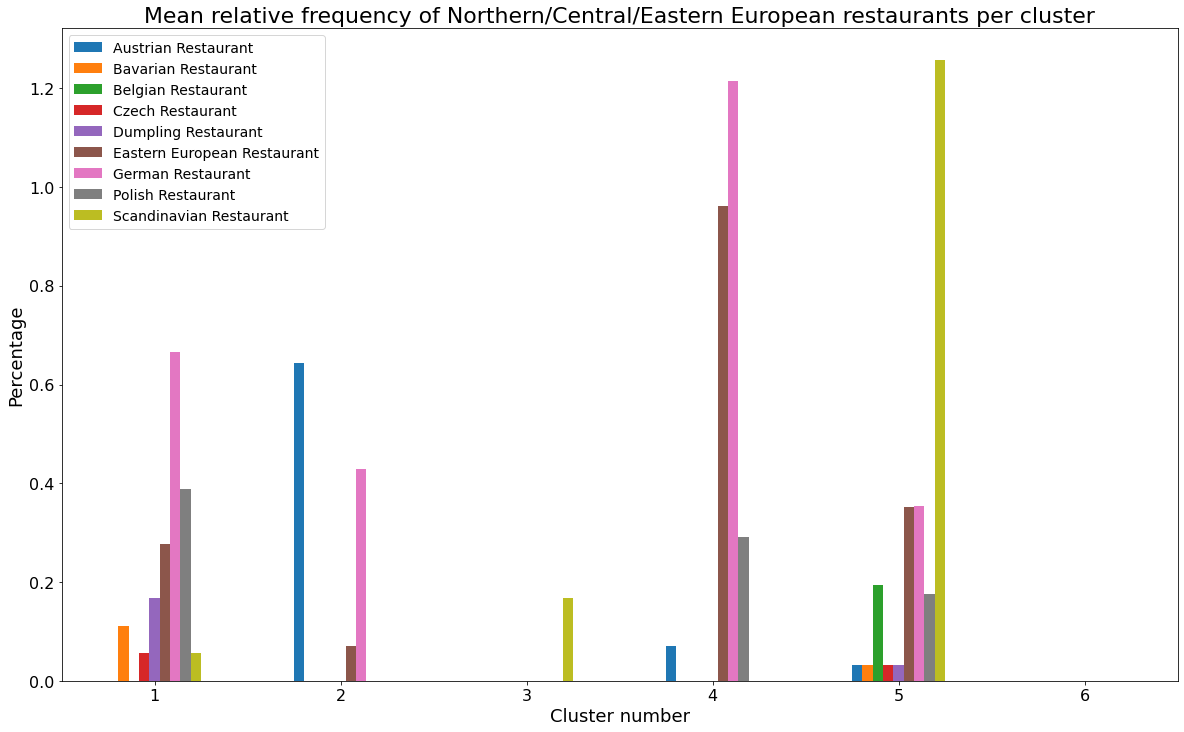

In [48]:
# Northern/Central/Eastern European restaurants
df_ncee_restaurants = eu_grouped_clustered.loc[:,["Austrian Restaurant", 
                                                  "Bavarian Restaurant", 
                                                  "Belgian Restaurant", 
                                                  "Czech Restaurant", 
                                                  "Dumpling Restaurant", 
                                                  "Eastern European Restaurant", 
                                                  "German Restaurant", 
                                                  "Polish Restaurant",
                                                  "Scandinavian Restaurant"]]

# Plot
df_ncee_restaurants.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of Northern/Central/Eastern European restaurants per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 14)

# Display
pyplot.show()

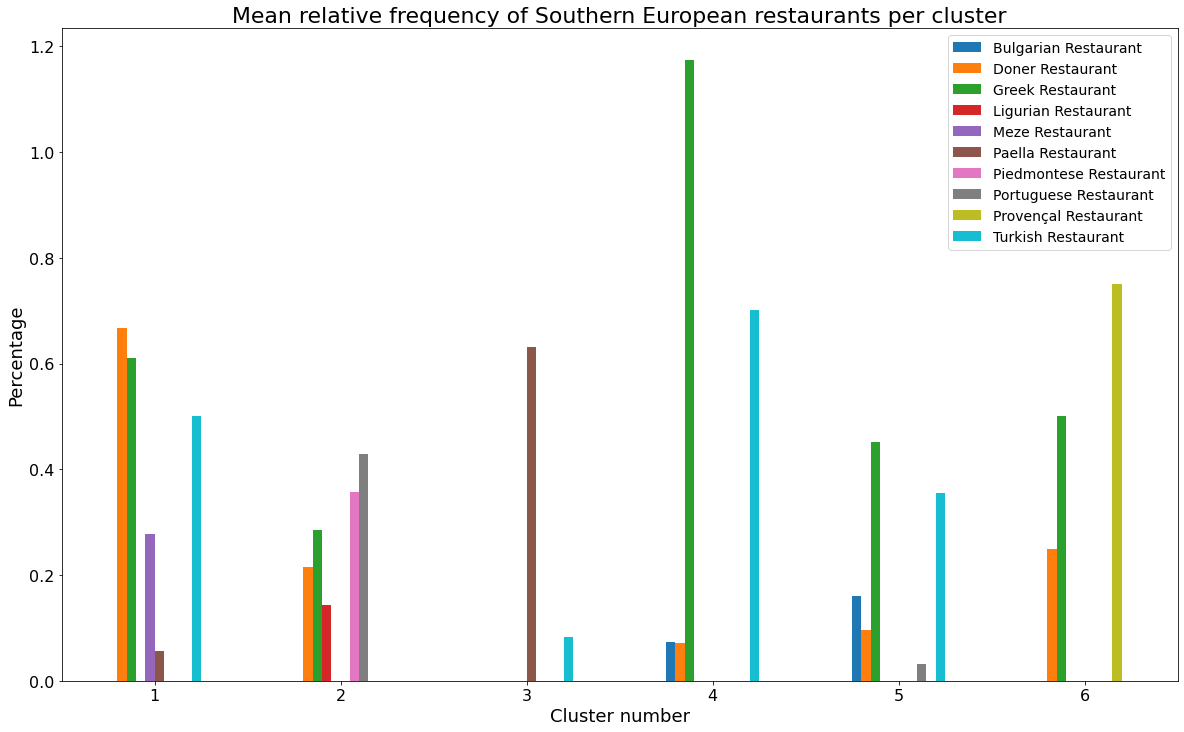

In [49]:
df_se_restaurants = eu_grouped_clustered.loc[:,["Bulgarian Restaurant", 
                                                "Doner Restaurant", 
                                                "Greek Restaurant",
                                                "Ligurian Restaurant",
                                                "Meze Restaurant",
                                                "Paella Restaurant",
                                                "Piedmontese Restaurant",
                                                "Portuguese Restaurant", 
                                                "Provençal Restaurant",
                                                "Turkish Restaurant"
                                               ]]

# Plot
df_se_restaurants.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of Southern European restaurants per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 14)

# Display
pyplot.show()

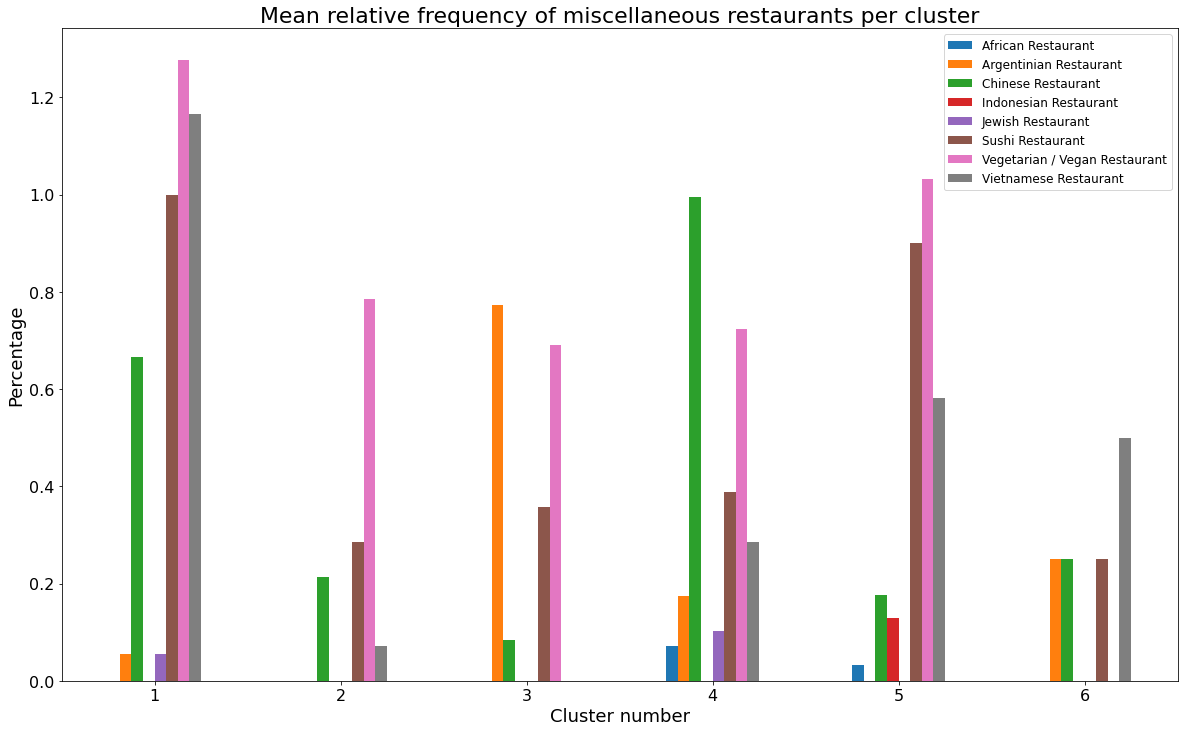

In [51]:
df_other_restaurants = eu_grouped_clustered.loc[:,["African Restaurant", 
                                                   "Argentinian Restaurant",
                                                   "Chinese Restaurant", 
                                                   "Indonesian Restaurant", 
                                                   "Jewish Restaurant",
                                                   "Sushi Restaurant", 
                                                   "Vegetarian / Vegan Restaurant", 
                                                   "Vietnamese Restaurant"
                                                  ]]

# Plot
df_other_restaurants.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of miscellaneous restaurants per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 12)

# Display
pyplot.show()

Let's also look at some cultural sites:

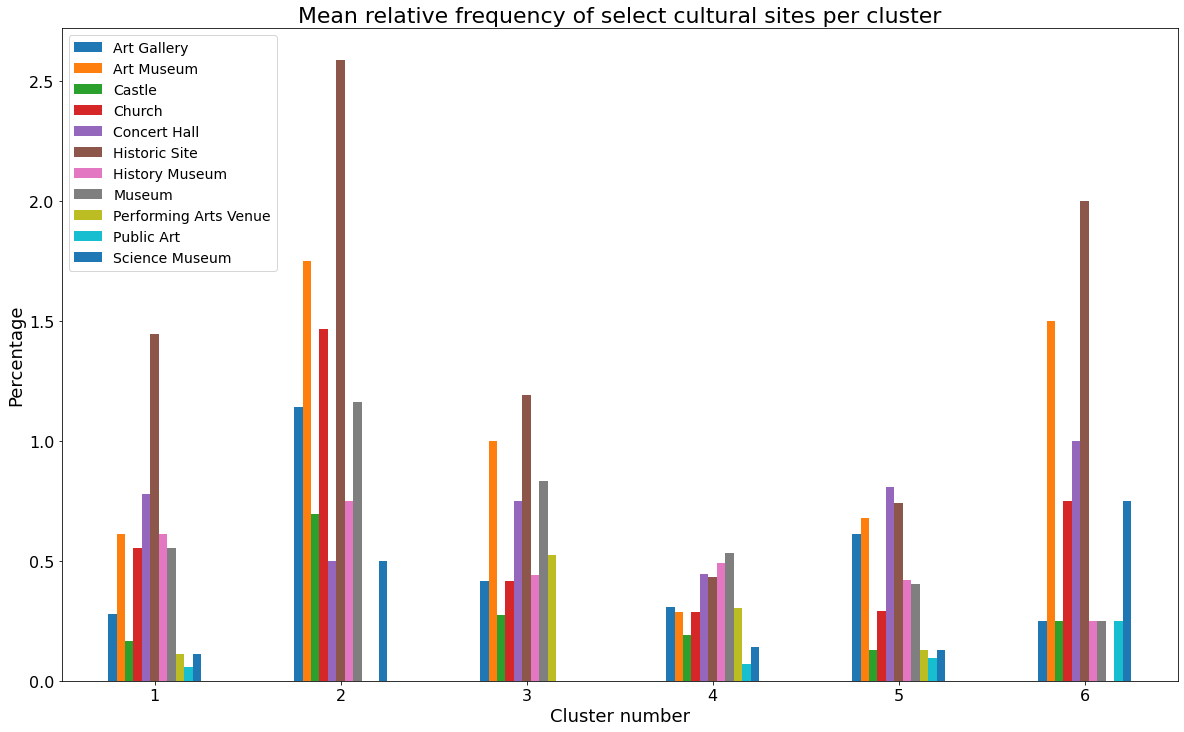

In [52]:
df_culture = eu_grouped_clustered.loc[:,["Art Gallery", 
                                         "Art Museum", 
                                         "Castle",
                                         "Church",
                                         "Concert Hall",
                                         "Historic Site",
                                         "History Museum",
                                         "Museum", 
                                         "Performing Arts Venue",
                                         "Public Art",
                                         "Science Museum"
                                        ]]

# Plot
df_culture.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of select cultural sites per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 14)

# Display
pyplot.show()

Food shops:

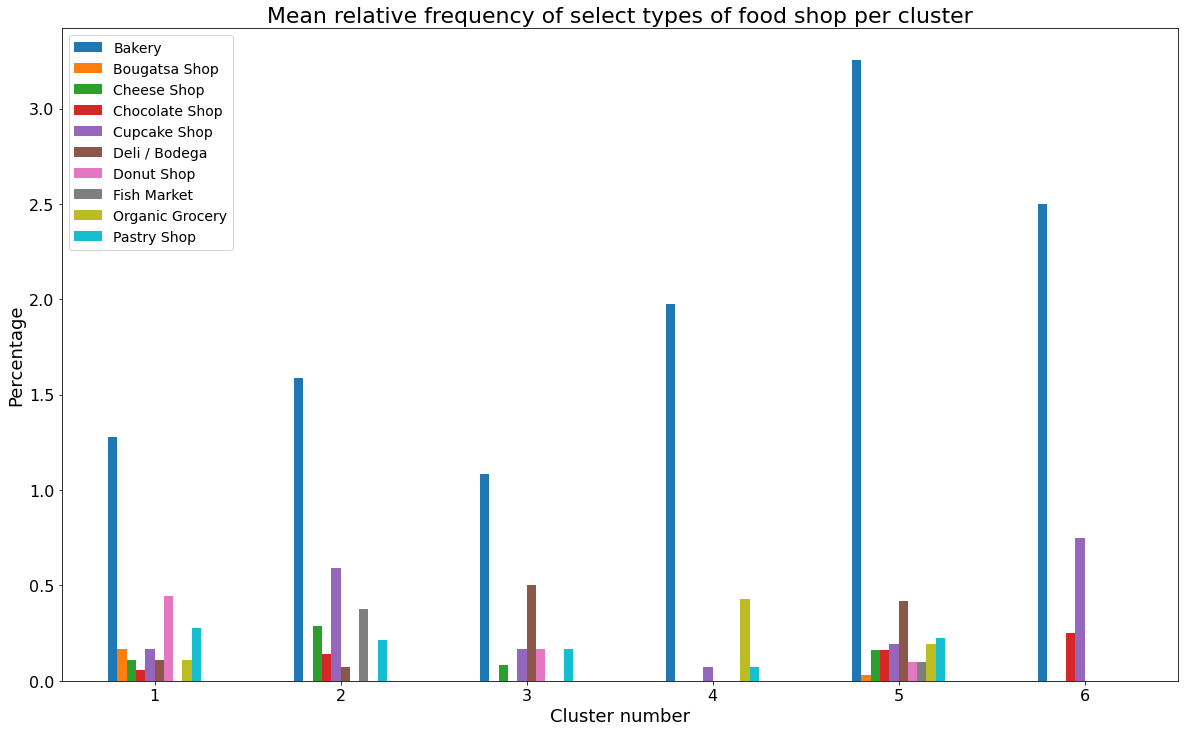

In [53]:
df_foodshops = eu_grouped_clustered.loc[:,["Bakery",
                                           "Bougatsa Shop",
                                           "Cheese Shop",
                                           "Chocolate Shop",
                                           "Cupcake Shop",
                                           "Deli / Bodega",
                                           "Donut Shop", 
                                           "Fish Market",
                                           "Organic Grocery", 
                                           "Pastry Shop"
                                          ]]

# Plot
df_foodshops.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of select types of food shop per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 14)

# Display
pyplot.show()

Nature:

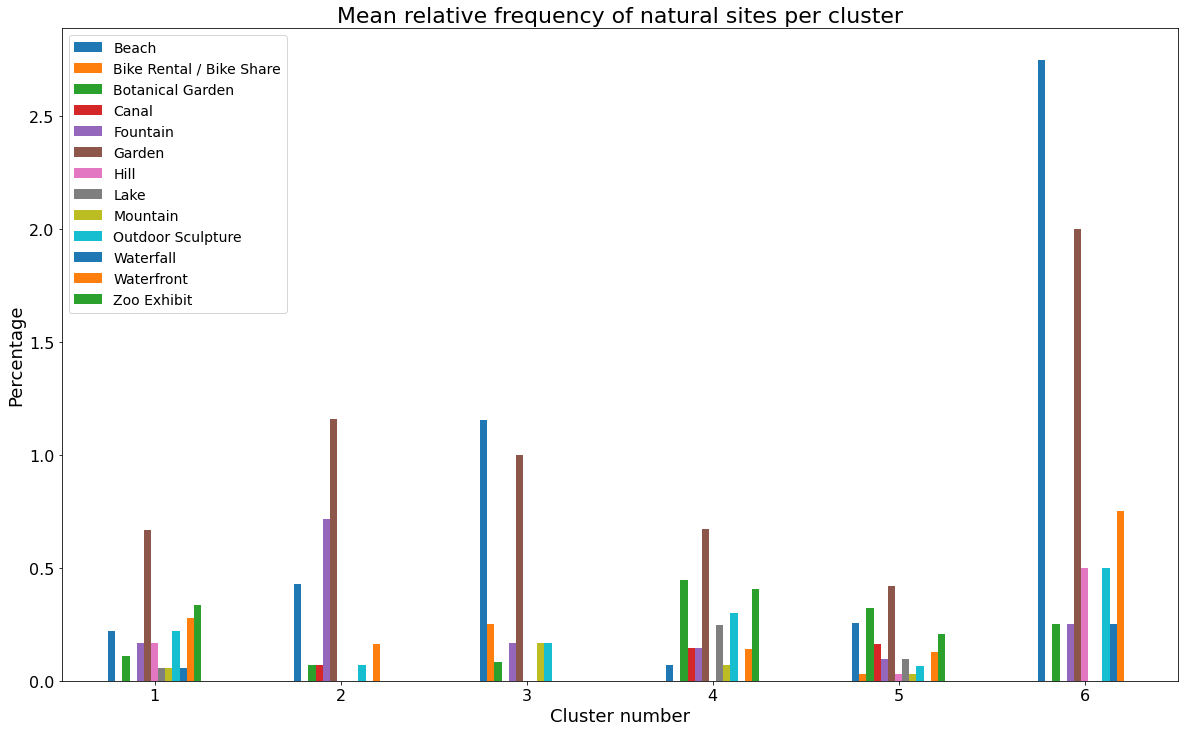

In [54]:
df_nature = eu_grouped_clustered.loc[:,["Beach",
                                        "Bike Rental / Bike Share", 
                                        "Botanical Garden", 
                                        "Canal",
                                        "Fountain", 
                                        "Garden", 
                                        "Hill",
                                        "Lake",
                                        "Mountain",
                                        "Outdoor Sculpture",
                                        "Waterfall",
                                        "Waterfront", 
                                        "Zoo Exhibit"
                                       ]]

# Plot
df_nature.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of natural sites per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 14)

# Display
pyplot.show()

Fun and leisure: 

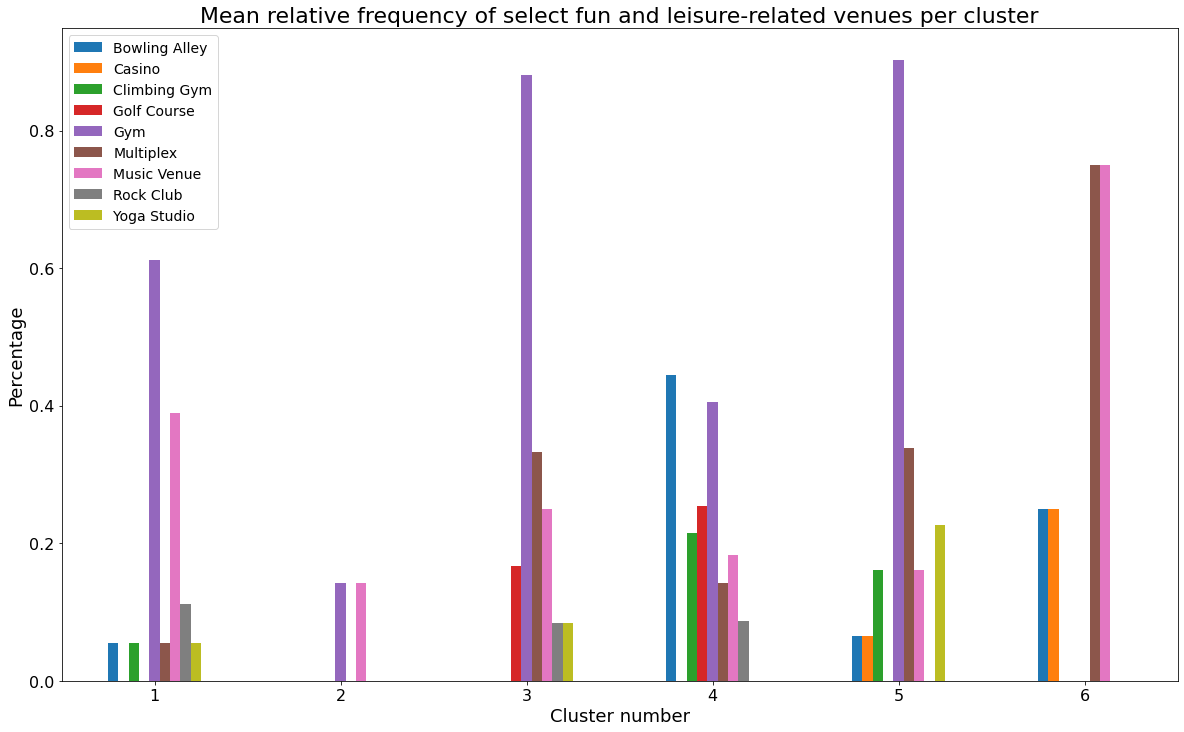

In [55]:
df_fun = eu_grouped_clustered.loc[:,["Bowling Alley",
                                     "Casino",
                                     "Climbing Gym",
                                     "Golf Course",
                                     "Gym",
                                     "Multiplex",
                                     "Music Venue",
                                     "Rock Club",
                                     "Yoga Studio"
                                    ]]

# Plot
df_fun.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of select fun and leisure-related venues per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 14)

# Display
pyplot.show()

And lastly some venues that had a really high percentage of frequency in one or more clusters:

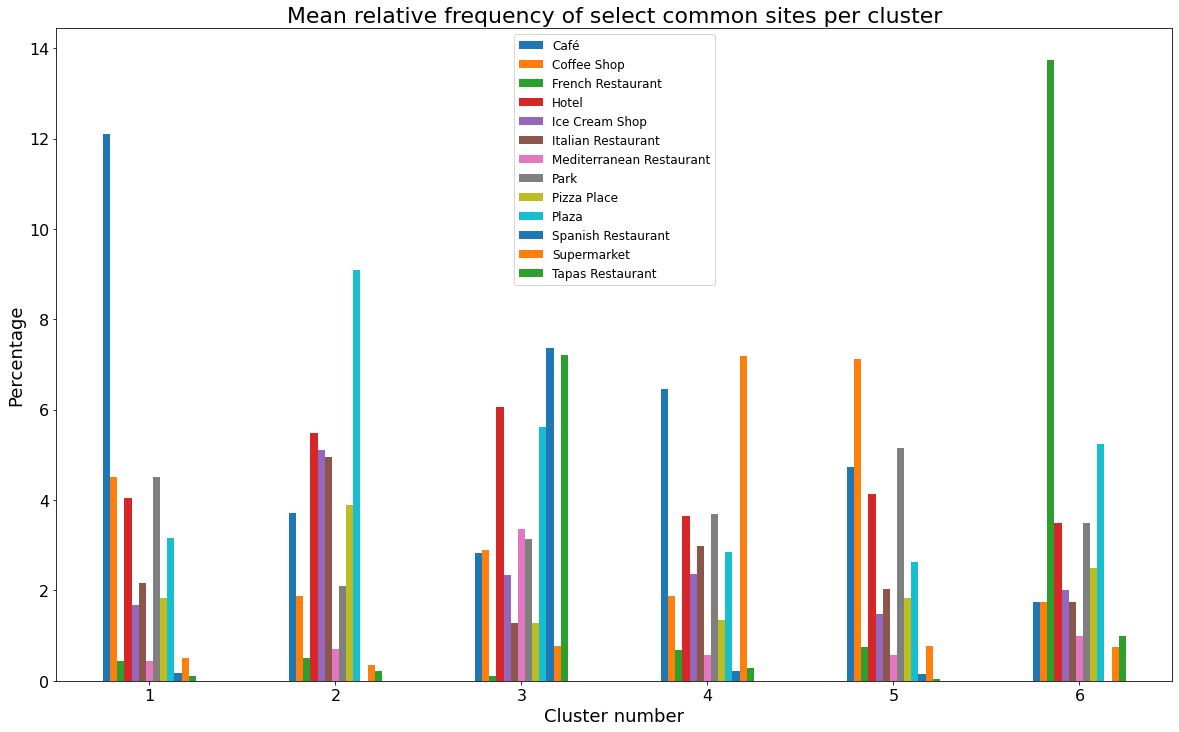

In [56]:
df_most_common = eu_grouped_clustered.loc[:,["Café",
                                             "Coffee Shop",
                                             "French Restaurant",
                                             "Hotel",
                                             "Ice Cream Shop",
                                             "Italian Restaurant",
                                             "Mediterranean Restaurant", 
                                             "Park",
                                             "Pizza Place",
                                             "Plaza",
                                             "Spanish Restaurant",
                                             "Supermarket",
                                             "Tapas Restaurant"
                                            ]]

# Plot
df_most_common.plot(kind = "bar", figsize = (20, 12))
pyplot.xlabel("Cluster number", fontsize = 18) # add x-label to the plot
pyplot.ylabel("Percentage", fontsize = 18) # add y-label to the plot
pyplot.title("Mean relative frequency of select common sites per cluster", fontsize = 22) # add title to the plot
pyplot.xticks(rotation = "horizontal", fontsize = 16)
pyplot.yticks(fontsize = 16)
pyplot.legend(fontsize = 12)

# Display
pyplot.show()